In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statistics
pd.set_option('display.max_columns',500)

In [2]:
df_2020 = pd.read_csv("csv_data/merged/Spring2020Merged_goodRuns.csv")
df_2023 = pd.read_csv("csv_data/merged/Spring2023Merged_goodRuns.csv")
df_2025 = pd.read_csv("csv_data/merged/Spring2025Merged_goodRuns.csv")

/var/folders/tp/y19c81b92lsc5dbbpwb5b0wh0000gn/T/ipykernel_3585/1971075393.py:1: DtypeWarning: Columns (31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2020 = pd.read_csv("csv_data/merged/Spring2020Merged_goodRuns.csv")
/var/folders/tp/y19c81b92lsc5dbbpwb5b0wh0000gn/T/ipykernel_3585/1971075393.py:2: DtypeWarning: Columns (32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023 = pd.read_csv("csv_data/merged/Spring2023Merged_goodRuns.csv")
/var/folders/tp/y19c81b92lsc5dbbpwb5b0wh0000gn/T/ipykernel_3585/1971075393.py:3: DtypeWarning: Columns (31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2025 = pd.read_csv("csv_data/merged/Spring2025Merged_goodRuns.csv")


In [3]:
def fixRunNumber(df_in):
    df_in['RunNumber'] = df_in['RunNumber'].astype(int)


fixRunNumber(df_2020)
fixRunNumber(df_2023)
fixRunNumber(df_2025)

In [4]:
# select runs with a nudge, and potential backlash based on motor inputs
df_2020_good = df_2020[(df_2020['RunHasNudge'])&(df_2020['RunHasBacklash'])&(df_2020['goodRun'])]
df_2023_good = df_2023[(df_2023['RunHasNudge'])&(df_2023['RunHasBacklash'])]
df_2025_good = df_2025[(df_2025['RunHasNudge'])&(df_2025['RunHasBacklash'])]


In [5]:
# copy viz code from other notebook (or make it a utility aviailble to all would be better)
backlash_runs_2020 = df_2020_good['RunNumber'].unique()
backlash_runs_2023 = df_2023_good['RunNumber'].unique()
backlash_runs_2025 = df_2025_good['RunNumber'].unique()


In [6]:
print(df_2020_good.columns)

Index(['Date-Time', 'RunNumber', 'DAQ:STATUS', 'CBREM:PLANE', 'GONI:ROLL',
       'GONI:ROLL.RBV', 'GONI:X', 'GONI:X.RBV', 'GONI:Y', 'GONI:Y.RBV',
       'GONI:PITCH', 'GONI:PITCH.RBV', 'GONI:YAW', 'GONI:YAW.RBV', 'AC:X',
       'AC:Y', 'EBEAM:CURRENT', 'EBEAM:ENERGY', 'EBEAM:X', 'EBEAM:Y',
       'CBREM:SET_ENERGY', 'CBREM:ENERGY_UNC', 'CBREM:ENERGY', 'RADIATOR:ID',
       'RADIATOR:NAME', 'goodRun', 'TimeStamp', 'NudgeDuringRun',
       'RunHasNudge', 'NudgeOccurred', 'TotalNudgeSize_thisRun',
       'NudgeSequence', 'NudgeSequenceReduced_Correct',
       'NudgeSequenceReduced_Naive', 'TotalNudges_thisRun',
       'RunHasAbnormalNudge', 'RunHasBacklash', 'BacklashNudge', 'NudgeNumber',
       'NudgePitchSize', 'NudgeYawSize', 'PitchMotionSize', 'YawMotionSize',
       'MotionDone', 'NudgeEnSize_10s', 'CBREM:ENERGY_LAG_ADJUSTED'],
      dtype='object')


In [7]:
print(df_2020_good['BacklashNudge'].value_counts())

BacklashNudge
False    781743
True        374
Name: count, dtype: int64


In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import statistics
pd.set_option('display.max_columns',500)

def plot_run(df_in, runNumber):
    runNumber = int(runNumber)

    # min and max coherent edge energy to include
    minE = 8550
    maxE = 8650
    expectedE = 8600

    roll_0_90 = -10.5
    roll_45_135 = 34.5

    titleRunPeriod = "Spring 20"
    runPeriod = "Spring2020"
    if (runNumber>80000) and (runNumber < 130000):
        runPeriod = 'Spring2023'
        titleRunPeriod = "Spring 23"
        minE = 8520
        maxE = 8720
        expectedE = 8620
        roll_0_90 = 162
        roll_45_135 = -153
    elif runNumber>130000:
        runPeriod = 'Spring2025'
        titleRunPeriod = "Spring 25"
        minE = 8800
        maxE = 9000
        expectedE = 8900
        roll_0_90 = -16.6
        roll_45_135 = 28.4


    print("plotting for run ",runNumber)

    # get df for just this run
    df_run = df_in[df_in['RunNumber']==runNumber]
    df_run.reset_index(inplace=True)

    print("Full nudge sequence is ",df_run['NudgeSequence'].mode())
    print("Reduced nudge sequence is ",df_run['NudgeSequenceReduced_Naive'].mode())
    print("Reduced nudge sequence w/ backlash is ",df_run['NudgeSequenceReduced_Correct'].mode())


    print(df_run['TotalNudges_thisRun'].unique(),"nudges this run")

    # only want to display neighborhood around nudges, so find time of first nudge
    df_tmp = df_run[df_run['NudgeNumber']==1]
    if df_tmp.empty:
        print("ERROR: First nudge df is empty, skipping Run",runNumber)
        return
    df_tmp.reset_index(inplace=True,drop=True)
    first_nudge_time = df_tmp.loc[0,'TimeStamp']

    df_run_nudges = df_run[(df_run['NudgeOccurred'])&(df_run['NudgeNumber']>=1)]

    # get the time when the DAQ turned on (status 2)
    df_daq_on = df_run[(df_run['DAQ:STATUS']==2)]
    df_daq_on.reset_index(inplace=True)
    daq_on_time = -100
    if not df_daq_on.empty:
        daq_on_time = df_daq_on.loc[0,'TimeStamp']

    max_nudge_time = df_run_nudges['TimeStamp'].max()
    # df for all times
    df_vis = df_run[(df_run['TimeStamp']>=first_nudge_time-30)&(df_run['TimeStamp']<=(max(daq_on_time,max_nudge_time)+30))&(df_run['CBREM:ENERGY']>minE)&(df_run['CBREM:ENERGY']<maxE)]
    df_vis.reset_index(inplace=True)


    nudge_list = df_run_nudges['NudgeNumber'].unique()

    fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
    
    up_nudge_label_set = False
    down_nudge_label_set = False
    backlash_label_set = False
    first_good_nudge = False

    nudge_times = []
    pitchDiffs = []
    yawDiffs = []
    set_ens = []

    first_nudge_time = 0
    max_nudge_time = 0

    
    # should be a list, can have backlash in both directions
    init_backlash_times = []# time of first backlash nudge
    end_backlash_times = []# time of last nudge to clear the backlash

    nudge_str = df_run_nudges['NudgeSequence'].mode()[0]
    if len(nudge_str)!=max(nudge_list):
        print("nudge_str length doesn't match nudge_list length")
        print(len(nudge_str))
        print(nudge_str)
        print(nudge_list)

    for seq in nudge_list:
       
        print("seq val is ",seq)
        nudge_dir = nudge_str[seq-1]
        df_this_nudge = df_run_nudges[df_run_nudges['NudgeNumber']==seq]
        df_this_nudge.reset_index(inplace=True)
        nudge_time = df_this_nudge.loc[0,'TimeStamp']
        #print(nudge_time)
        if first_nudge_time==0:
            first_nudge_time = nudge_time

        current_pitchDiff = df_this_nudge.loc[0,'NudgePitchSize']        
        current_yawDiff = df_this_nudge.loc[0,'NudgeYawSize']
        current_roll = df_this_nudge.loc[0,'GONI:ROLL']

        outStr = "0_90"
        orStr = "0/90 "
        if current_roll>0:
            orStr = "45/135 "
            outStr = "45_135"


        nudge_has_backlash = df_this_nudge.loc[0,'BacklashNudge']

        # no clue what is causing this, nudges should never be this big. Config change?
        if abs(current_pitchDiff)>1 or abs(current_yawDiff)>1:
            #print(df_this_nudge)
            continue

        pitchDiffs.append(current_pitchDiff)
        yawDiffs.append(current_yawDiff)
        nudge_times.append(nudge_time)
            
        if nudge_time>max_nudge_time:
            max_nudge_time = nudge_time


        
        if nudge_has_backlash:
            init_backlash_times.append(nudge_time)
            end_backlash_times.append(nudge_time)
            if not backlash_label_set:
                ax1.axvline(nudge_time,color='gray',linestyle='--',label='Backlash')
                backlash_label_set = True 
            else:
                ax1.axvline(nudge_time,color='gray',linestyle='--')
        else:
            if nudge_dir=='u':
                if not up_nudge_label_set:
                    ax1.axvline(nudge_time,color='lime',linestyle='--',label='Up Nudge')
                    up_nudge_label_set = True
                else:
                    ax1.axvline(nudge_time,color='lime',linestyle='--')
            if nudge_dir=='d':
                if not down_nudge_label_set:
                    ax1.axvline(nudge_time,color='r',linestyle='--',label='Down Nudge')
                    down_nudge_label_set = True
                else:
                    ax1.axvline(nudge_time,color='r',linestyle='--')


 
    # df to get 30 seconds after daq on or last nudge, which ever is later 
    df_end = df_run[(df_run['TimeStamp']>=max(max_nudge_time,daq_on_time))]
    df_end.reset_index(inplace=True)

    end_times = list(df_end.loc[0:60,'TimeStamp'])
    if len(end_times)==0:
        end_times.append(max_nudge_time+15)

    ax2.plot(nudge_times,yawDiffs,marker='o',label='Yaw Diff')
    ax2.plot(nudge_times,pitchDiffs,marker='o',label='Pitch Diff')




    if len(end_times)>0:
        ax1.axvline(daq_on_time,color='black',label='DAQ On')

        if end_times[0]>max_nudge_time:
            nudge_times+=end_times
            

        # for more than one backlash event, 
    for i in range(len(init_backlash_times)):
        ax1.axvspan(init_backlash_times[i],end_backlash_times[i]+15,color='gray',alpha=0.1)


    plt.xlabel("Time Stamp (s)")


    ax1.plot(df_vis['TimeStamp'],df_vis['CBREM:ENERGY'],color='b')
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    
    ax1.axhspan(expectedE-10,expectedE+10,color='g',alpha=0.1)

    ax2.legend()
    
    plane_value = df_end.loc[0,'CBREM:PLANE']

    plane_str = 'PARA'
    if plane_value==2:
        plane_str = "PERP"
    elif plane_value==0:
        plane_str = " Undefined"

    radiator_name = df_vis['RADIATOR:NAME'].mode()[0]
    print(df_vis['RADIATOR:NAME'].value_counts())
    
    titleStr = runPeriod+'Run '+str(runNumber)+" "+orStr+" "+plane_str+" "+radiator_name
    
    ax1.set_title(titleStr)

    ax1.set_ylabel("Photon Energy (GeV)")
    ax1.legend()

    

    
    plt.savefig("plots/backlash/"+outStr+"_"+plane_str+"/plot_run_"+str(runNumber)+".pdf")
    plt.show()

    plt.clf()


plotting for run  72102
Full nudge sequence is  0    dduuuuuuuuuuudd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuuuuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[15] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
seq val is  14
seq val is  15
RADIATOR:NAME
JD70-105    294
Name: count, dtype: int64


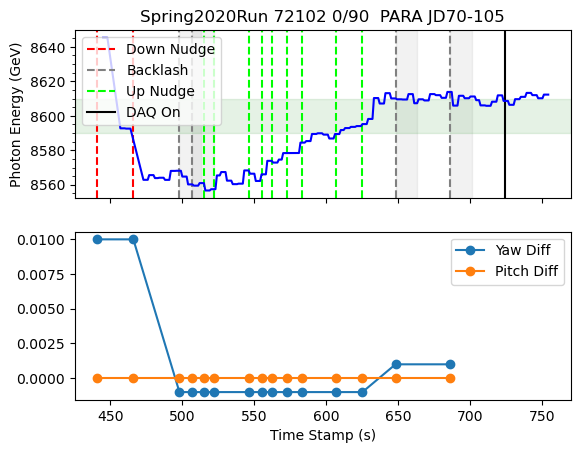

plotting for run  72104
Full nudge sequence is  0    udduuuuuuuuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuuuuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuuuuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[14] nudges this run
nudge_str length doesn't match nudge_list length
14
udduuuuuuuuuuu
[1 2]
seq val is  1
seq val is  2
RADIATOR:NAME
JD70-105     48
Undefined    26
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

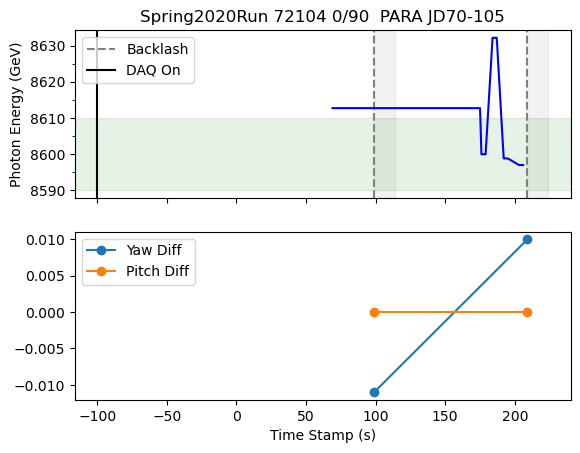

plotting for run  72105
Full nudge sequence is  0    dd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD70-105    171
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

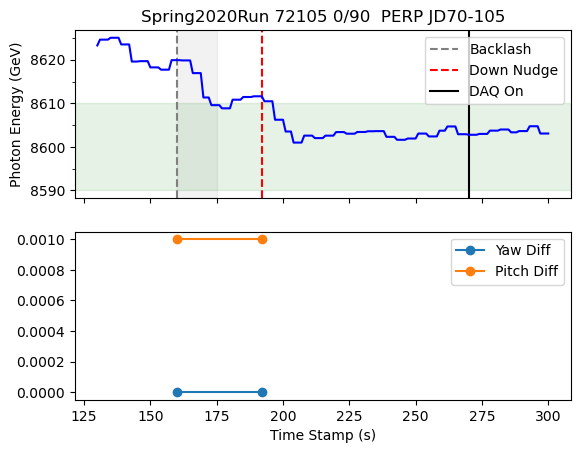

plotting for run  72107
Full nudge sequence is  0    duuuuudduuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuu
Name: NudgeSequenceReduced_Correct, dtype: object
[12] nudges this run
nudge_str length doesn't match nudge_list length
11
duuuuudduuu
[ 1  2  3  4  5  6  7  8  9 10 11 12]
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12


IndexError: string index out of range

<Figure size 640x480 with 0 Axes>

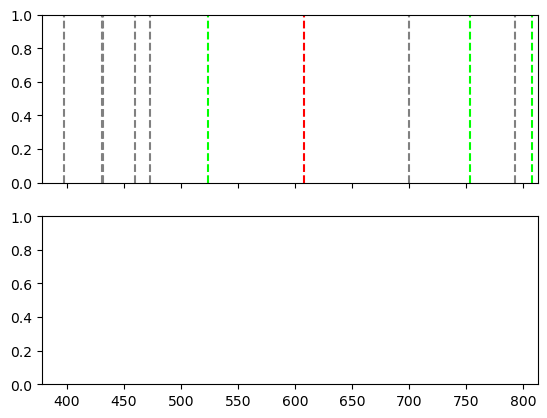

In [36]:
for runNum in backlash_runs_2020:
    plot_run(df_2020_good,runNum)

plotting for run  120311
[814] nudges this run
RADIATOR:NAME
JD70-103     13959
Undefined     1032
JD70-107         5
Name: count, dtype: int64


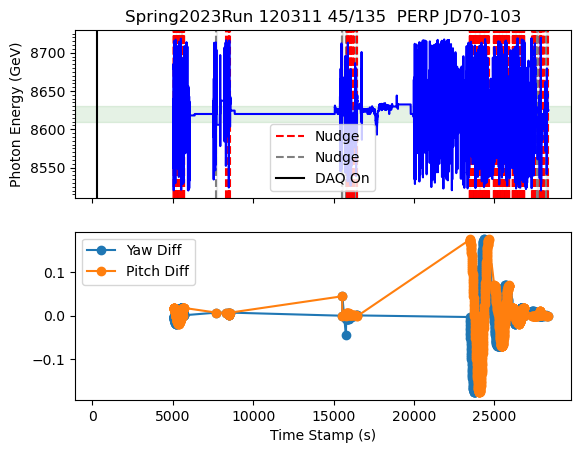

plotting for run  120313
[3] nudges this run
RADIATOR:NAME
JD70-103    140
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

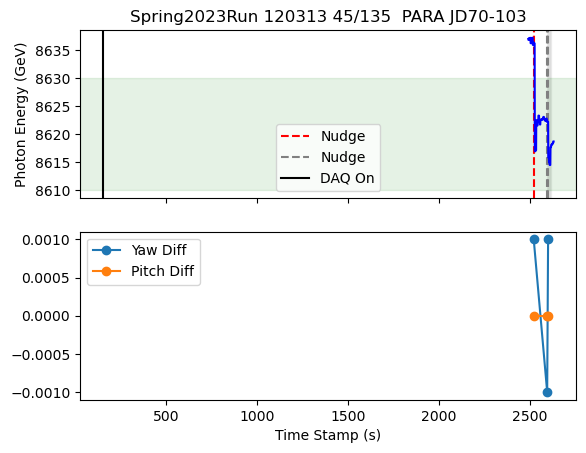

plotting for run  120315
[1] nudges this run
RADIATOR:NAME
JD70-103     1695
Undefined      26
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

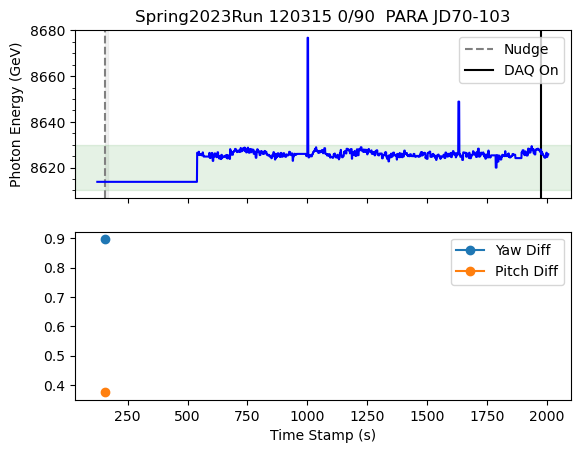

plotting for run  120322
[1] nudges this run
RADIATOR:NAME
JD70-103    253
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

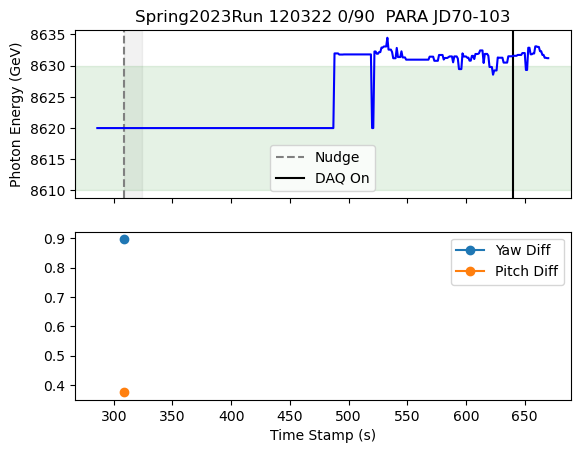

plotting for run  120372
[1] nudges this run
RADIATOR:NAME
JD70-103    727
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

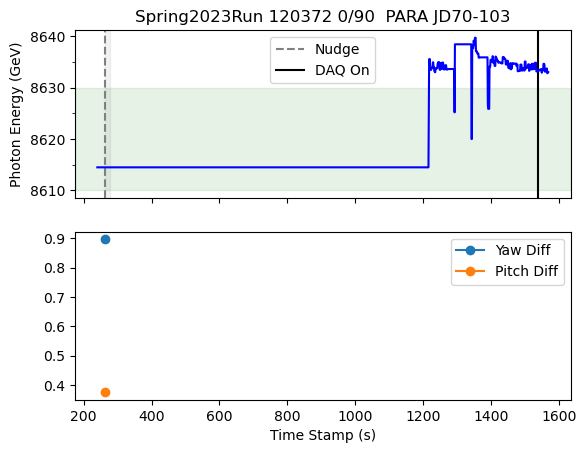

plotting for run  120398
[1] nudges this run
RADIATOR:NAME
JD70-103     633
Undefined      5
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

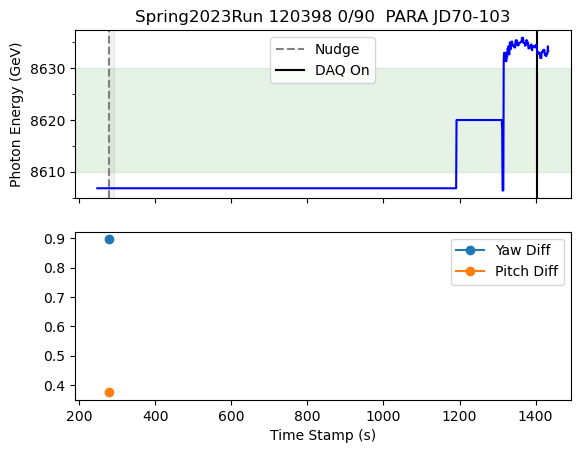

plotting for run  120404
[1] nudges this run
RADIATOR:NAME
JD70-103    135
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

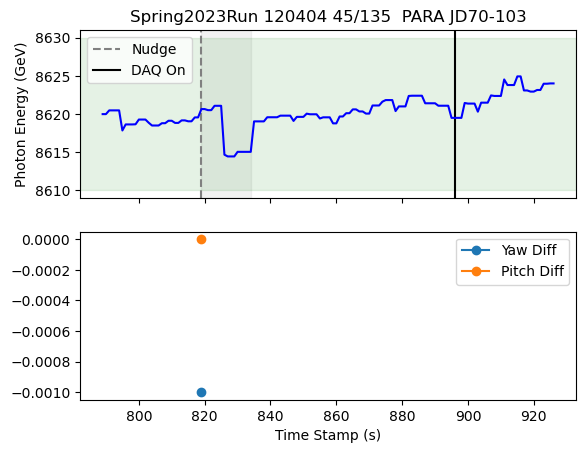

plotting for run  120406
[11] nudges this run
RADIATOR:NAME
JD70-103    266
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

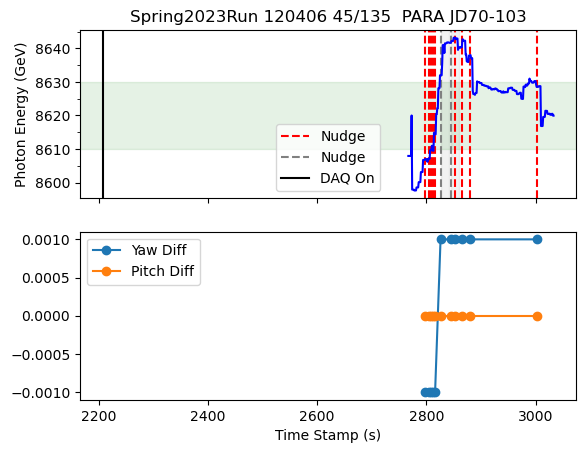

plotting for run  120411
[1] nudges this run
RADIATOR:NAME
JD70-103     315
Undefined     21
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

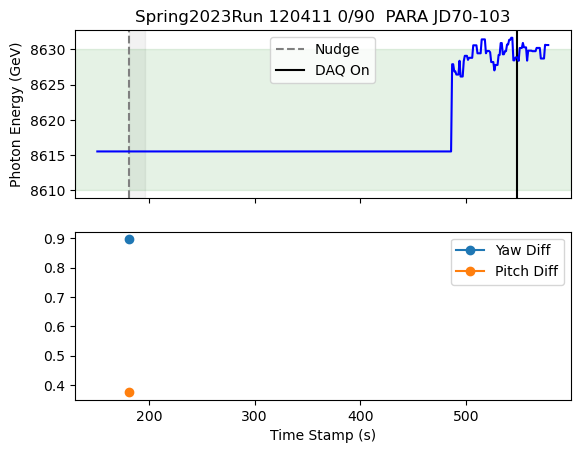

plotting for run  120420
[5] nudges this run
RADIATOR:NAME
JD70-103    485
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

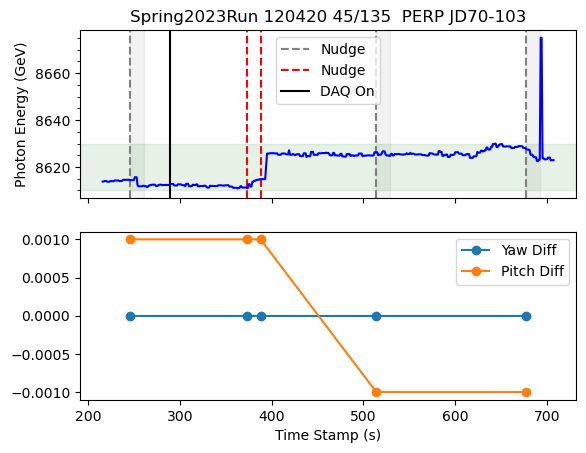

plotting for run  120437
[1] nudges this run
RADIATOR:NAME
JD70-103    211
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

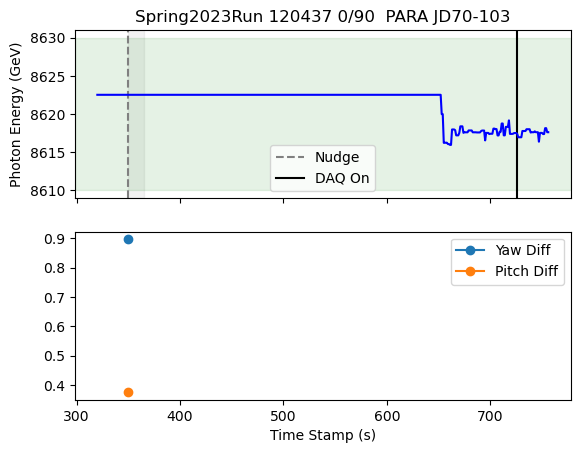

plotting for run  120451
[1] nudges this run
RADIATOR:NAME
JD70-103    294
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

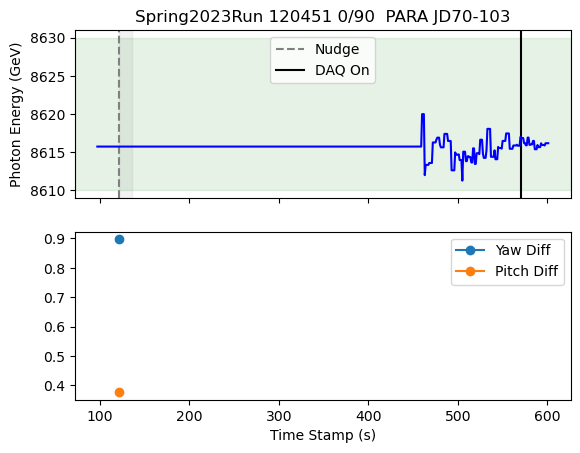

plotting for run  120470
[1] nudges this run
RADIATOR:NAME
JD70-103    163
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

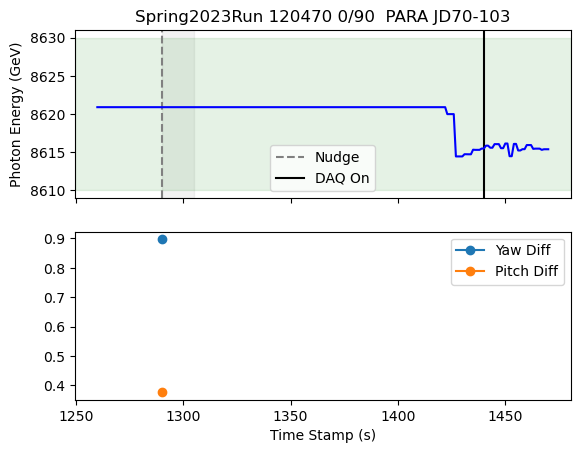

plotting for run  120536
[1] nudges this run
RADIATOR:NAME
JD70-103     353
Undefined      2
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

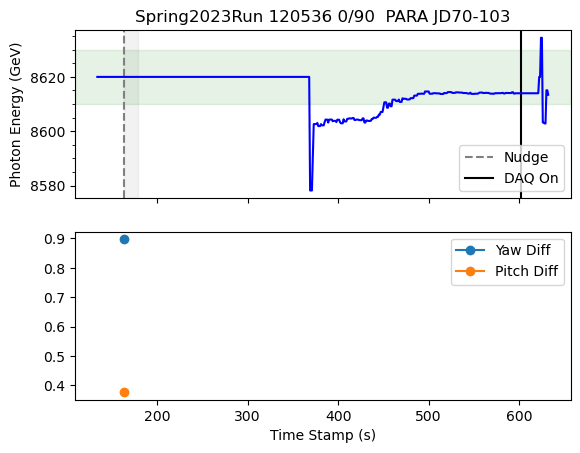

plotting for run  120541
[2] nudges this run
RADIATOR:NAME
JD70-103    62
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

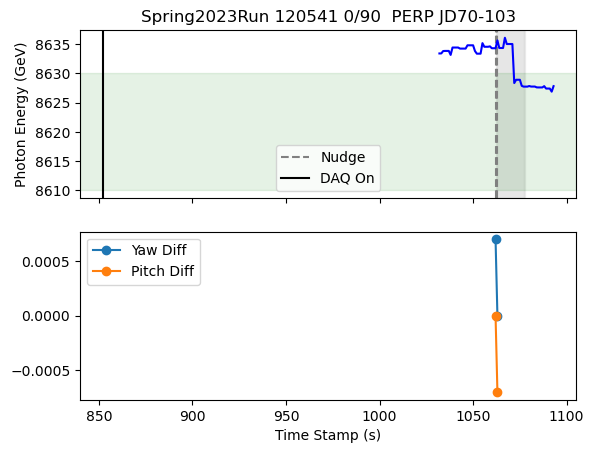

plotting for run  120562
[1] nudges this run
RADIATOR:NAME
JD70-103    176
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

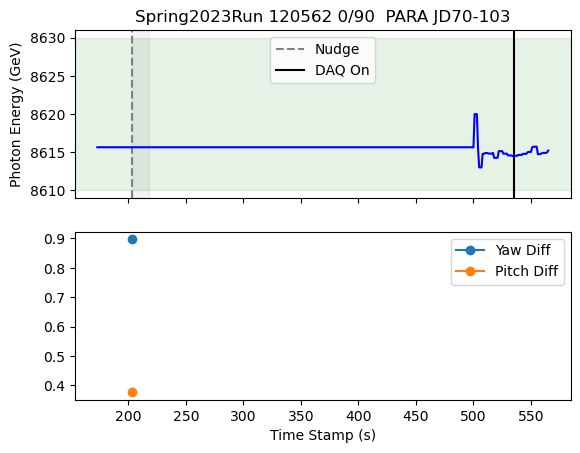

plotting for run  120566
[1] nudges this run
RADIATOR:NAME
JD70-103    80
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

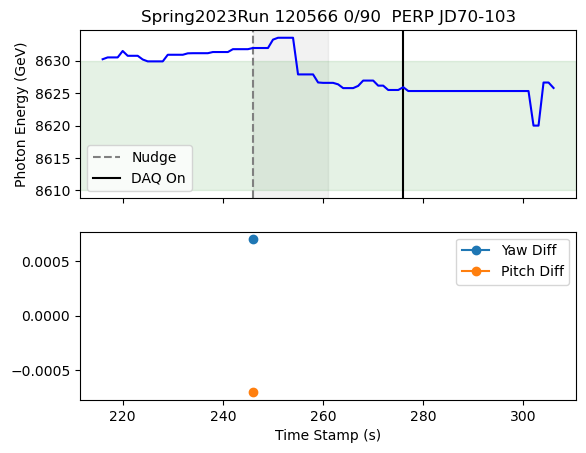

plotting for run  120606
[1] nudges this run
RADIATOR:NAME
JD70-103     125
Undefined      9
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

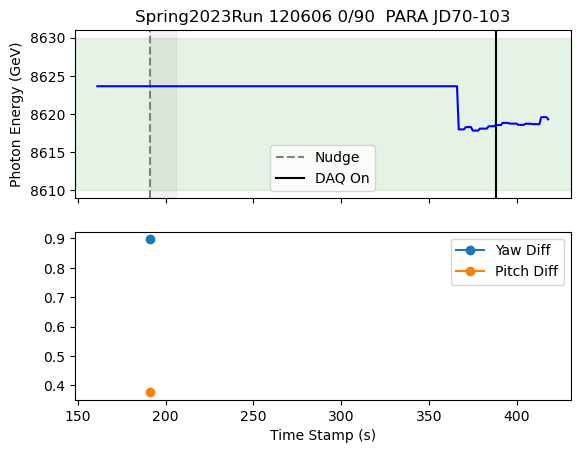

plotting for run  120663
[1] nudges this run
RADIATOR:NAME
JD70-103    207
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

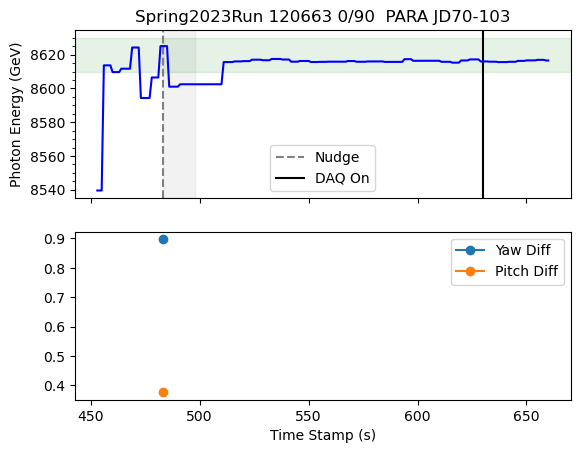

plotting for run  120687
[1] nudges this run
RADIATOR:NAME
JD70-103    194
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

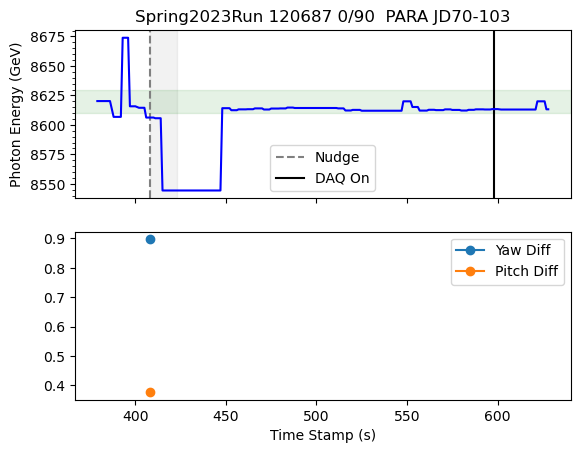

plotting for run  120706
[1] nudges this run
RADIATOR:NAME
JD70-103    48
Name: count, dtype: int64


FileNotFoundError: [Errno 2] No such file or directory: 'plots/backlash/0_90_ Undefined/plot_run_120706.pdf'

<Figure size 640x480 with 0 Axes>

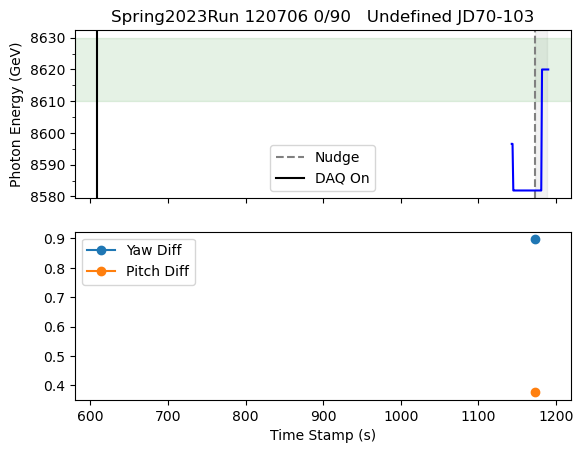

In [10]:
for runNum in backlash_runs_2023:
    plot_run(df_2023_good,runNum)

In [ ]:
for runNum in backlash_runs_2025:
    plot_run(df_2025_good,runNum)